## Day 34 Lecture 2 Assignment

In this assignment, we will learn about gradient boosting. We will use a dataset of house information in Ames, Iowa, predicting sale price.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
house = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/houseprices.csv')
print(house.shape)
house.head()

(1460, 81)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Check for nulls. Remove any columns with more than 100 nulls, then drop any remaining rows with nulls after that.

In [4]:
# your work here
house.isnull().sum().sort_values(ascending=False).head(20)

poolqc          1453
miscfeature     1406
alley           1369
fence           1179
fireplacequ      690
lotfrontage      259
garagecond        81
garagetype        81
garageyrblt       81
garagefinish      81
garagequal        81
bsmtexposure      38
bsmtfintype2      38
bsmtfintype1      37
bsmtcond          37
bsmtqual          37
masvnrarea         8
masvnrtype         8
electrical         1
utilities          0
dtype: int64

In [5]:
house_df = house.drop(['poolqc','miscfeature','alley','fence','fireplacequ','lotfrontage'], axis=1)

new_house = house_df.dropna()

new_house.isnull().sum().sort_values(ascending=False)

saleprice       0
yearremodadd    0
roofmatl        0
exterior1st     0
exterior2nd     0
               ..
kitchenabvgr    0
kitchenqual     0
totrmsabvgrd    0
functional      0
id              0
Length: 75, dtype: int64

One hot encode your categorical features using get_dummies.

In [6]:
# your work here
new_house.describe(include=["O"])

,mszoning,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfintype2,heating,heatingqc,centralair,electrical,kitchenqual,functional,garagetype,garagefinish,garagequal,garagecond,paveddrive,saletype,salecondition
count,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338,1338
unique,5,2,4,4,2,5,3,25,9,8,5,8,6,8,14,16,4,4,4,5,4,4,4,6,6,4,5,2,5,4,7,6,3,5,5,3,9,6
top,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,Unf,TA,TA,Y,WD,Normal
freq,1066,1333,829,1206,1337,957,1265,209,1162,1324,1138,657,1037,1314,486,475,763,803,1183,620,594,1237,887,402,1176,1318,704,1277,1242,650,1254,852,580,1270,1287,1257,1158,1104


In [7]:
house_data = pd.get_dummies(new_house,drop_first=True)

house_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1459
Columns: 228 entries, id to salecondition_Partial
dtypes: float64(2), int64(35), uint8(191)
memory usage: 646.8 KB


Take a look at your outcome variable. It is highly skewed, and has a few very rare large outliers.

Let's try log transforming the y variable.

(array([ 91., 676., 358., 133.,  52.,  17.,   4.,   3.,   2.,   2.]),
 array([ 35311. , 107279.9, 179248.8, 251217.7, 323186.6, 395155.5,
        467124.4, 539093.3, 611062.2, 683031.1, 755000. ]),
 <a list of 10 Patch objects>)

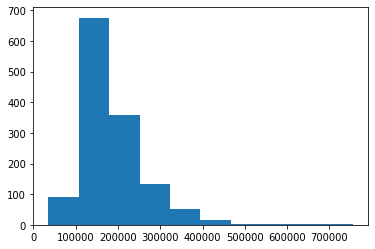

In [8]:
# your work here
plt.hist(house_data['saleprice'])

In [9]:

house_data.saleprice.describe()

count      1338.000000
mean     186761.782511
std       78913.847668
min       35311.000000
25%      135000.000000
50%      168500.000000
75%      220000.000000
max      755000.000000
Name: saleprice, dtype: float64

In [11]:
house_data['saleprice'] = np.log(house_data['saleprice'])

In [12]:

house_data.saleprice.describe()

count    1338.000000
mean        2.489698
std         0.031145
min         2.348700
25%         2.469203
50%         2.487793
75%         2.509712
max         2.605240
Name: saleprice, dtype: float64

We know that there are some rare large values. We can make sure that the training and test sets have about the same distribution by stratifying the train-test split.

Split your training and test sets, with a test size of 0.2. Use the given helper function to stratify the continuous outcome. Remember that the outcome variable is now the **log of sale price**.

In [13]:
def binned(y, num_bins):
    # Creates an object to put in the stratify keyword in train_test_split
    # Specify number of bins to separate your y variable
    ymin, ymax = y.min(), y.max()
    bins = np.linspace(ymin, ymax, num_bins+1)[:-1]
    y_binned = np.digitize(y, bins)
    return y_binned

In [16]:
# your work here
from sklearn.model_selection import train_test_split

X = house_data.drop('saleprice', axis=1)
y = house_data['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=binned(y,5))

Create a Gradient Boosting Regressor model. Measure the MAE (Mean Absolute Error) for the training and testing sets.

In [19]:
# your work here

from sklearn.metrics import mean_squared_error

def scores(model, X, y):
  r2 = model.score(X,y)
  y_pred = model.predict(X)
  #squared = False turns MSE into RMSE
  mse = mean_squared_error(y, y_pred, squared=True)
  return r2, mse

def results(model, X_train, X_test, y_train, y_test):
  r2_train, mse_train = scores(model, X_train, y_train)
  r2_test, mse_test = scores(model, X_test, y_test)
  return (f'Train\tR2: {r2_train:.5f}\tMSE: {mse_train:.5f}\n Test\tR2: {r2_test:.5f}\tMSE: {mse_test:.5f}')

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

grad = GradientBoostingRegressor()

grad.fit(X_train, y_train)

print(results(grad,X_train,X_test,y_train,y_test))

Train	R2: 0.96166	MSE: 0.00004
 Test	R2: 0.86419	MSE: 0.00013


Create a grid search. Try varying subsample, learning rate, and max features. Use MAE as your scoring metric.

In [21]:
# your work here

from sklearn.model_selection import GridSearchCV
from datetime import datetime

start_time = datetime.now()
param_grid = {'subsample': [.7,.8,.9],'learning_rate': [.05,.1], 'max_features':[.5,.75,1], 
              'n_iter_no_change': [10], 'n_estimators':[1000]}

grad = GradientBoostingRegressor()

grad_grid = GridSearchCV(grad, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

grad_grid.fit(X_train, y_train)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:06.218234


In [22]:
print("Best subsample hyperpararmeter using MSE scoring: ",grad_grid.best_estimator_.subsample)
print("Best learning rate hyperpararmeter using MSE scoring: ",grad_grid.best_estimator_.learning_rate)
print("Best max features hyperpararmeter using MSE scoring: ",grad_grid.best_estimator_.max_features)

Best subsample hyperpararmeter using MSE scoring:  0.7
Best learning rate hyperpararmeter using MSE scoring:  0.1
Best max features hyperpararmeter using MSE scoring:  0.75


In [23]:

best_grad = grad = GradientBoostingRegressor(subsample=.8, learning_rate=.1,max_features=.5,n_iter_no_change=10,n_estimators=1000)

best_grad.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=0.5, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=10, presort='deprecated',
                          random_state=None, subsample=0.8, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
print(results(best_grad,X_train,X_test,y_train,y_test))

Train	R2: 0.87226	MSE: 0.00012
 Test	R2: 0.79368	MSE: 0.00020


Create residual plots of the training and test sets and interpret your results.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


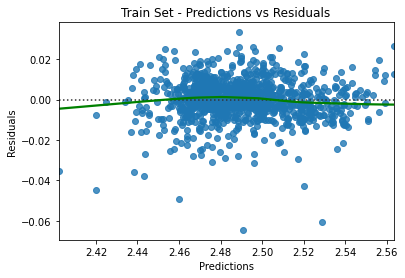

In [25]:
# your work here
train_pred = best_grad.predict(X_train)
res = y_train - train_pred

sns.residplot(train_pred, res, lowess=True, line_kws={'color':'green'})
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Train Set - Predictions vs Residuals')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


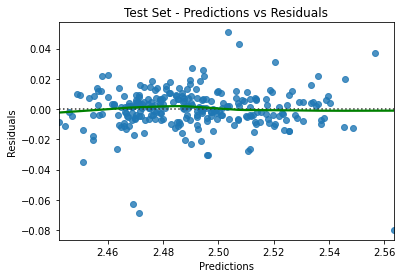

In [26]:

test_pred = best_grad.predict(X_test)
res = y_test - test_pred

sns.residplot(test_pred, res, lowess=True, line_kws={'color':'green'})
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Test Set - Predictions vs Residuals')
plt.show()

In [ ]:
#evidence of overfitting. 
#The train sets errors do cluster closer to zero than the test set. 
#The test set has a less of a cluster around zero and more sporadic erros than the train set.